In [14]:
import pandas as pd
import matplotlib.pyplot as plt
from os import walk
from os.path import join

import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from bs4 import BeautifulSoup

from wordcloud import WordCloud
from PIL import Image
import numpy as np

from sklearn.model_selection import train_test_split

%matplotlib inline

In [15]:
SPAM_1_PATH = "01_Processing/spam_assassin_corpus/spam_1"
SPAM_2_PATH = "01_Processing/spam_assassin_corpus/spam_2"
EASY_NONSPAM_1_PATH = "01_Processing/spam_assassin_corpus/easy_ham_1"
EASY_NONSPAM_2_PATH = "01_Processing/spam_assassin_corpus/easy_ham_2"

SPAM_CAT = 1
HAM_CAT = 0
VOCAB_SIZE = 2500

DATA_JSON_FILE = "01_Processing/email-text-data.json"
WORD_ID_FILE = "01_Processing/word-by-id.csv"

WHALE_FILE = "01_Processing/wordcloud_resources/whale-icon.png"
SKULL_FILE = "01_Processing/wordcloud_resources/skull-icon.png"

TRAINING_DATA_FILE = "02_Training/train-data.txt"
TEST_DATA_FILE = "02_Training/test-data.txt"

# Convert File to Email Text

In [19]:
def email_body_generator(path):
    for root, dirnames, filenames in walk(path):
        for file_name in filenames:
            filepath = join(root, file_name)
            stream = open(filepath, encoding="latin-1")
            is_body = False
            lines = []
            for line in stream: 
                if is_body: 
                    lines.append(line)
                elif line=="\n": 
                    is_body=True
            stream.close()
            email_body = "\n".join(lines)
            yield file_name, email_body

# Convert All Files into Email Bodies

In [17]:
def df_from_directory(path, classification):
    rows = []
    row_names = []
    for file_name, email_body in email_body_generator(path):
        rows.append({"Message":email_body, "Category":classification})
        row_names.append(file_name)
    return pd.DataFrame(rows, index=row_names)

# Create Data Frame of All Emails

In [20]:
#create dataframe
spam_emails = df_from_directory(SPAM_1_PATH, SPAM_CAT)
spam_emails = spam_emails.append(df_from_directory(SPAM_2_PATH, SPAM_CAT))
ham_emails = df_from_directory(EASY_NONSPAM_1_PATH, HAM_CAT)
ham_emails = ham_emails.append(df_from_directory(EASY_NONSPAM_2_PATH, HAM_CAT))
data = pd.concat([spam_emails, ham_emails])

In [21]:
# returns True if any element is null
data["Message"].isnull().values.any()
# finds how many messages are empty strings
(data["Message"].str.len()==0).sum()

3

In [22]:
drop_idx = data[data.Message.str.len()==0].index
# inplace=True means that we don't need to re-assign the "data" variable
data.drop(drop_idx, inplace=True)

In [23]:
document_ids = range(0, len(data.index))
data["Doc_Id"] = document_ids
data.set_index("Doc_Id", inplace=True)

# Save Data to JSON File

In [24]:
data.to_json(DATA_JSON_FILE)

# Create Pie Chart

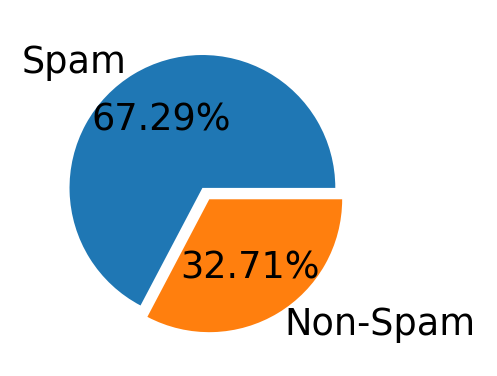

In [21]:
amount_of_spam = data["Category"].value_counts()[0]
amount_of_ham = data["Category"].value_counts()[1]
plt.figure(figsize=(2,2), dpi=220)
plt.pie([amount_of_spam, amount_of_ham], labels=["Spam", "Non-Spam"], textprops={"fontsize": 12}, autopct="%1.2f%%", explode=[0,0.1])
plt.show()

# Create Donut Chart

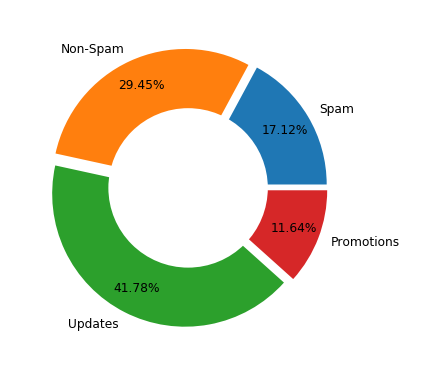

In [22]:
plt.figure(figsize=(2,2), dpi=220)
offset = [0.05 for i in range(0,4)]
plt.pie([25, 43, 61, 17], labels=["Spam", "Non-Spam", "Updates", "Promotions"], textprops={"fontsize": 4}, autopct="%1.2f%%", pctdistance=0.8, explode=offset)

center_circle = plt.Circle((0,0), 0.6, fc="white")
plt.gca().add_artist(center_circle)
plt.show()

# Natural Language Processing
### Pre-Processing Text Data

In [23]:
nltk.download("punkt")
nltk.download("stopwords")

[nltk_data] Downloading package punkt to C:\Users\Srivinay
[nltk_data]     Tummarakota\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Srivinay
[nltk_data]     Tummarakota\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [25]:
def clean_message(message, stemmer=PorterStemmer(), stop_words=set(stopwords.words("english"))):
    soup = BeautifulSoup(message, "html.parser")
    message = soup.get_text()
    words = word_tokenize(message.lower())
    filtered_words = []
    for word in words: 
        if word not in stop_words and word.isalpha():
            filtered_words.append(stemmer.stem(word))
    return filtered_words

In [26]:
nested_list = data.Message.apply(clean_message)

C:\Users\Srivinay Tummarakota\anaconda3\lib\site-packages\bs4\__init__.py:389: UserWarning: "http://www.post-gazette.com/columnists/20020905brian5
" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


In [27]:
doc_ids_spam = data[data.Category==1].index
doc_ids_ham = data[data.Category==0].index
nested_list_spam = nested_list.loc[doc_ids_spam]
nested_list_ham = nested_list.loc[doc_ids_ham]

In [27]:
spam_words = pd.Series([word for word_list in nested_list_spam for word in word_list])
spam_words.value_counts()[:10]

http      3101
email     3094
free      2555
click     2058
receiv    1987
list      1974
get       1903
pleas     1842
busi      1792
order     1743
dtype: int64

In [28]:
ham_words = pd.Series([word for word_list in nested_list_ham for word in word_list])
ham_words.value_counts()[:10]

http      7561
use       3630
list      2878
one       2371
get       2284
mail      2255
would     2003
like      1928
messag    1847
work      1798
dtype: int64

 # Creating a Word Cloud

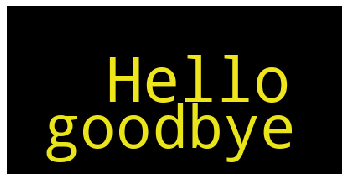

In [29]:
word_cloud = WordCloud().generate("Hello goodbye")
plt.axis("off", interpolation="bilinear")
plt.imshow(word_cloud)

In [30]:
nltk.download('shakespeare')
nltk.download('gutenberg')

[nltk_data] Downloading package shakespeare to C:\Users\Srivinay
[nltk_data]     Tummarakota\AppData\Roaming\nltk_data...
[nltk_data]   Package shakespeare is already up-to-date!
[nltk_data] Downloading package gutenberg to C:\Users\Srivinay
[nltk_data]     Tummarakota\AppData\Roaming\nltk_data...
[nltk_data]   Package gutenberg is already up-to-date!


True

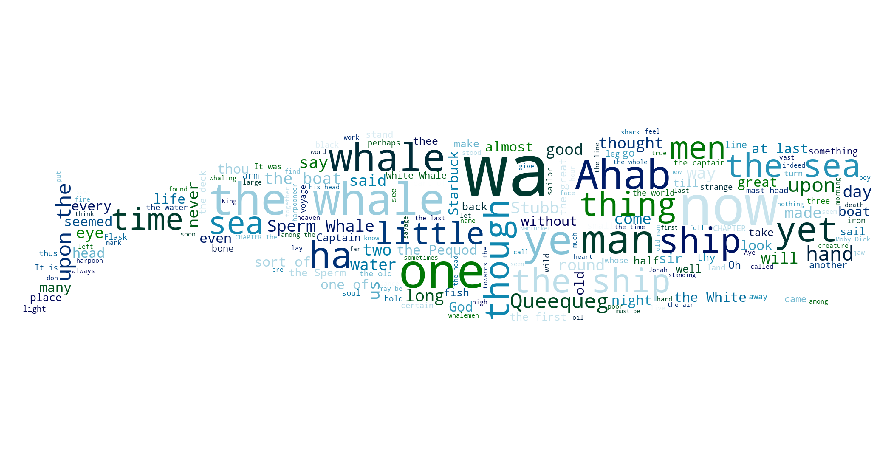

In [31]:
example_corpus = nltk.corpus.gutenberg.words("melville-moby_dick.txt")
word_list = [''.join(word) for word in example_corpus]
novel_as_string = ' '.join(word_list)

icon = Image.open(WHALE_FILE)
image_mask = Image.new(mode="RGB", size=icon.size, color=(255,255,255))
image_mask.paste(icon, box=icon)
rgb_array = np.array(image_mask)

word_cloud = WordCloud(mask=rgb_array, background_color="white", colormap="ocean").generate(novel_as_string)
plt.figure(figsize=(16,8))
plt.axis("off", interpolation="bilinear")
plt.imshow(word_cloud)

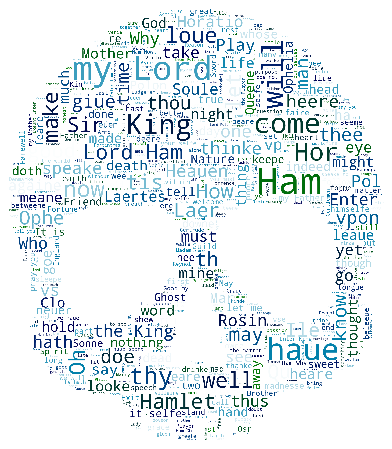

In [32]:
example_corpus = nltk.corpus.gutenberg.words("shakespeare-hamlet.txt")
word_list = [''.join(word) for word in example_corpus]
novel_as_string = ' '.join(word_list)

icon = Image.open(SKULL_FILE)
image_mask = Image.new(mode="RGB", size=icon.size, color=(255,255,255))
image_mask.paste(icon, box=icon)
rgb_array = np.array(image_mask)

word_cloud = WordCloud(mask=rgb_array, background_color="white", colormap="ocean", max_words=600).generate(novel_as_string)
plt.figure(figsize=(16,8))
plt.axis("off", interpolation="bilinear")
plt.imshow(word_cloud)

# Generate Vocabulary and Dictionary

In [28]:
stemmed_nested_list = data["Message"].apply(clean_message)
flat_stemmed_list = [item for sublist in stemmed_nested_list for item in sublist]

In [29]:
unique_words = pd.Series(flat_stemmed_list).value_counts()
frequent_words = unique_words[0:VOCAB_SIZE]
word_ids = list(range(0, VOCAB_SIZE))
vocab = pd.DataFrame({"VOCAB_WORDS":frequent_words.index.values}, index=word_ids)
vocab.index.name="WORD_ID"
vocab.to_csv(WORD_ID_FILE, index_label=vocab.index.name, header=vocab.VOCAB_WORDS.name)

In [35]:
email_lengths = [len(words) for words in nested_list.values]
max_email_idx = np.argmax(email_lengths)
print(nested_list[max_email_idx])
print(data.loc[max_email_idx, "Message"])

['yahoo', 'group', 'sponsor', 'dvd', 'free', 'p', 'join', 'http', 'new', 'version', 'unison', 'avail', 'test', 'incorpor', 'sever', 'small', 'improv', 'main', 'chang', 'fix', 'bug', 'potenti', 'seriou', 'safeti', 'consequ', 'small', 'number', 'user', 'habit', 'run', 'one', 'instanc', 'unison', 'time', 'parallel', 'user', 'strongli', 'encourag', 'upgrad', 'other', 'wait', 'wish', 'releas', 'includ', 'execut', 'linux', 'solari', 'window', 'look', 'maintain', 'moment', 'none', 'activ', 'develop', 'regularli', 'use', 'unison', 'window', 'machin', 'configur', 'properli', 'build', 'execut', 'export', 'grab', 'http', 'enjoy', 'benjamin', 'chang', 'sinc', 'ad', 'prefer', 'maxthread', 'use', 'limit', 'number', 'simultan', 'file', 'transfer', 'ad', 'backupdir', 'prefer', 'control', 'backup', 'file', 'store', 'basic', 'support', 'ad', 'osx', 'particular', 'unison', 'recogn', 'one', 'host', 'synchron', 'run', 'osx', 'switch', 'treatment', 'filenam', 'consid', 'file', 'osx', 'yet', 'fulli', 'work',

# Generate Features & Sparse Matrix

In [30]:
word_columns_df = pd.DataFrame.from_records(stemmed_nested_list.tolist())

In [31]:
X_train, X_test, y_train, y_test = train_test_split(word_columns_df, data["Category"], test_size=0.3, random_state=42)
X_train.index.name = X_test.index.name = "Doc_Id"
X_train.head()

,0,1,2,3,4,5,6,7,8,9,...,7661,7662,7663,7664,7665,7666,7667,7668,7669,7670
Doc_Id,,,,,,,,,,,,,,,,,,,,,
4844,ye,inde,agent,directori,verita,cd,unix,subdirectori,file,call,...,None,None,None,None,None,None,None,None,None,None
4727,problem,come,tri,instal,harddissssk,like,alreadi,mount,http,yahoo,...,None,None,None,None,None,None,None,None,None,None
5022,origin,messag,date,mon,aug,chad,norwood,sven,cc,subject,...,None,None,None,None,None,None,None,None,None,None
3504,inlin,folk,sever,major,internet,outag,morn,across,major,provid,...,None,None,None,None,None,None,None,None,None,None
3921,url,http,date,bath,chronicl,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


In [32]:
def make_sparse_matrix(df, indexed_words, labels): 
    dict_list = []
    nr_rows = df.shape[0]
    nr_cols = df.shape[1]
    word_set = set(indexed_words)
    for row in range(nr_rows):
        for col in range(nr_cols):
            word = df.iat[row, col]
            if word in word_set: 
                doc_id = df.index[row]
                word_id = indexed_words.get_loc(word)
                category = labels.at[doc_id]
                item = {"DOC_ID":doc_id, "WORD_ID": word_id, "OCCURRENCE": 1, "CATEGORY":category}
                dict_list.append(item)
    return pd.DataFrame(dict_list)

In [33]:
word_index = pd.Index(vocab["VOCAB_WORDS"])
sparse_train_df = make_sparse_matrix(X_train, word_index, y_train)

In [34]:
trained_group = sparse_train_df.groupby(["DOC_ID", "WORD_ID", "CATEGORY"]).sum()
trained_group = trained_group.reset_index()
np.savetxt(TRAINING_DATA_FILE, trained_group, fmt="%d")

In [35]:
sparse_test_df = make_sparse_matrix(X_test, word_index, y_test)

In [36]:
test_group = sparse_test_df.groupby(["DOC_ID", "WORD_ID", "CATEGORY"]).sum()
test_group = test_group.reset_index()
np.savetxt(TEST_DATA_FILE, test_group, fmt="%d")

In [43]:
set(X_train.index.values) - set(trained_group["DOC_ID"])
data.loc[22, "Message"]

'------=_NextPart_000_00B2_83B03D1E.C6530E24\n\nContent-Type: text/html; charset="iso-8859-1"\n\nContent-Transfer-Encoding: base64\n\n\n\n\n\nPGh0bWw+PGJvZHk+PGRpdiBpZD0ibWVzc2FnZUJvZHkiPjxkaXY+PGZvbnQg\n\nZmFjZT0iQXJpYWwiIHNpemU9IjIiPlRoaXMgbWVzc2FnZSBpcyBzZW50IHRv\n\nIG91ciBzdWJzY3JpYmVycyBvbmx5LiBGdXJ0aGVyIGVtYWlscyB0byB5b3Ug\n\nYnkgdGhlIHNlbmRlciB0aGlzIG9uZSB3aWxsIGJlIHN1c3BlbmRlZCBhdCBu\n\nbyBjb3N0IHRvIHlvdS4gU2NyZWVuaW5nIG9mIGFkZHJlc3NlcyBoYXMgYmVl\n\nbiBkb25lIHRvIHRoZSBiZXN0IG9mIG91ciBhYmlsaXR5LCB1bmZvcnR1bmF0\n\nZWx5IGl0IGlzIGltcG9zc2libGUgdG8gYmUgMTAwJSBhY2N1cmF0ZSwgc28g\n\naWYgeW91IGRpZCBub3QgYXNrIGZvciB0aGlzLCBvciB3aXNoIHRvIGJlIGV4\n\nY2x1ZGVkIG9mIHRoaXMgbGlzdCwgcGxlYXNlIGNsaWNrIDxhIGhyZWY9Im1h\n\naWx0bzpoZWFsdGgxMDVAbWFpbC5ydT9zdWJqZWN0PXJlbW92ZSIgdGFyZ2V0\n\nPSJuZXdfd2luIj5oZXJlPC9hPjwvZm9udD48L2Rpdj4gIDxwPjxiPjxmb250\n\nIGZhY2U9IkFyaWFsIj48Zm9udCBjb2xvcj0iI2ZmMDAwMCI+VEhJUyBJUyBG\n\nT1IgQURVTFQgTUVOIE9OTFkgISBJRiBZT1UgQVJFIE5PVCBBTiBBRFVMVCwg\n\nREVMRVRFIE5PVyAhDQo8cD4NCj